# Electromiografía: Cuantificación de inicios y finales de estímulos.
### Flores Oliva Alejandro Elliot
#### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

## Índice:

[1. Configuración/Diseño del notebook. ](#1)

[2. Extraer y graficar los datos. ](#2)

[3. Filtración de las grabaciones.](#3)

[4. Filtro Butterworth de paso banda.](#4)

[5. Valor absoluto de EMG.](#5)

[6. Análisis de registros mediante cuantificaciones. ](#6)

<a id='1'></a>
## Configuración/Diseño del notebook.

Importamos los módulos de Python para trazar figuras, gráficos en el cuaderno y crear figuras con buena resolución y etiquetas grandes.

#### Librerías utilizadas
Importamos las librerías/ módulos que nos permitirán hacer cálculos, filtrar datos, utilizar filtros, análisis, etc.

In [1]:
#Importamos las librerías necesarias para este notebook.
import scipy.io.wavfile         #El módulo de “wave”proporciona una interfaz conveniente para el formato de sonido WAV.
import numpy as np              #Es una biblioteca para crear vectores y matrices grandes multidimensionales.
import matplotlib.pyplot as plt #Nos provee de un framework de gráficos parecido a MATLAB.
from scipy.signal import butter, lfilter, filtfilt #Herramientas de procesamiento de señales, funciones de filtrado, algoritmos de interpolación.
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import math            #Permite usar funciones matemáticas definidas en el estándar de C.
import scipy as sc     #Módulos para álgebra lineal, integración, interpolación, FFT, procesamiento de señales y de imagen, etc.
from scipy import signal 
import wave            #El módulo proporciona una interfaz para el formato de sonido WAV.
import math            #Permite usar funciones matemáticas definidas en el estándar de C.
import os              #Interfaces misceláneas del sistema operativo.
import pandas as pd    #Sirve para el manejo y análisis de estructuras de datos.
import scipy as sc     #Funciones importadas de numpy.

<a id='2'></a>
## Extraer y graficar los datos.

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio [.wav]. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

Número de canales (estéreo o mono) : 2
Longitud de onda en segundos 207.4505
[0.000000e+00 1.000000e-04 2.000000e-04 ... 2.074502e+02 2.074503e+02
 2.074504e+02]


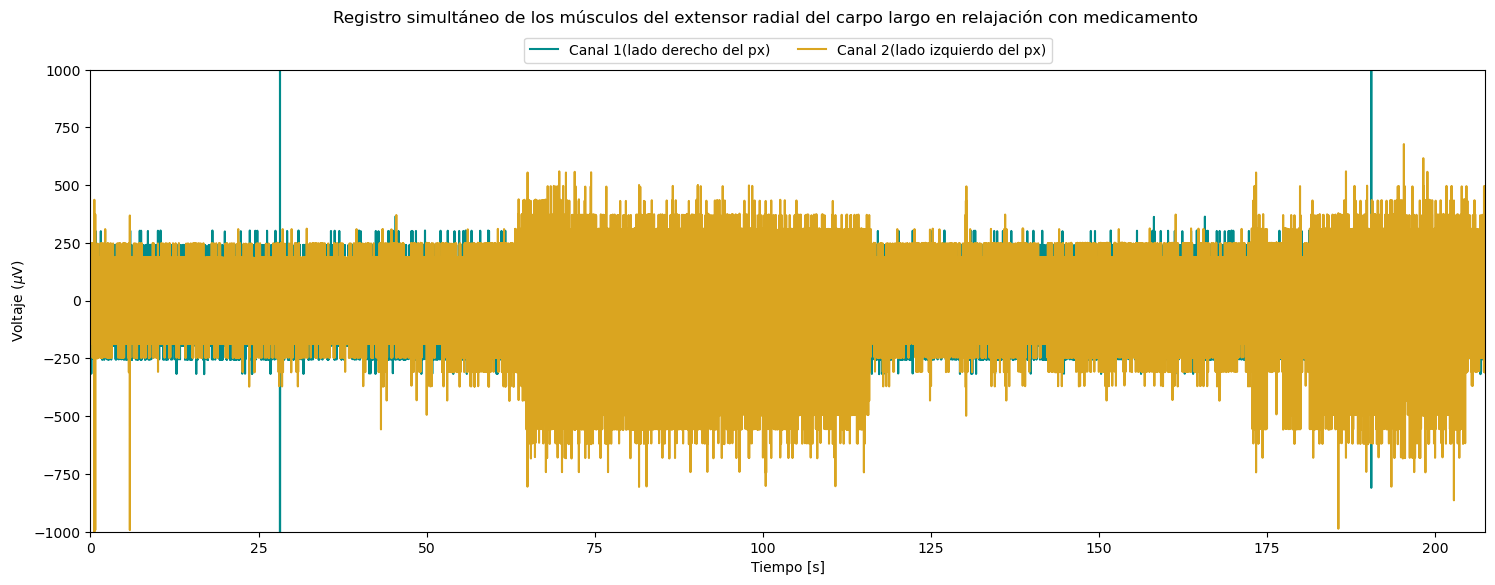

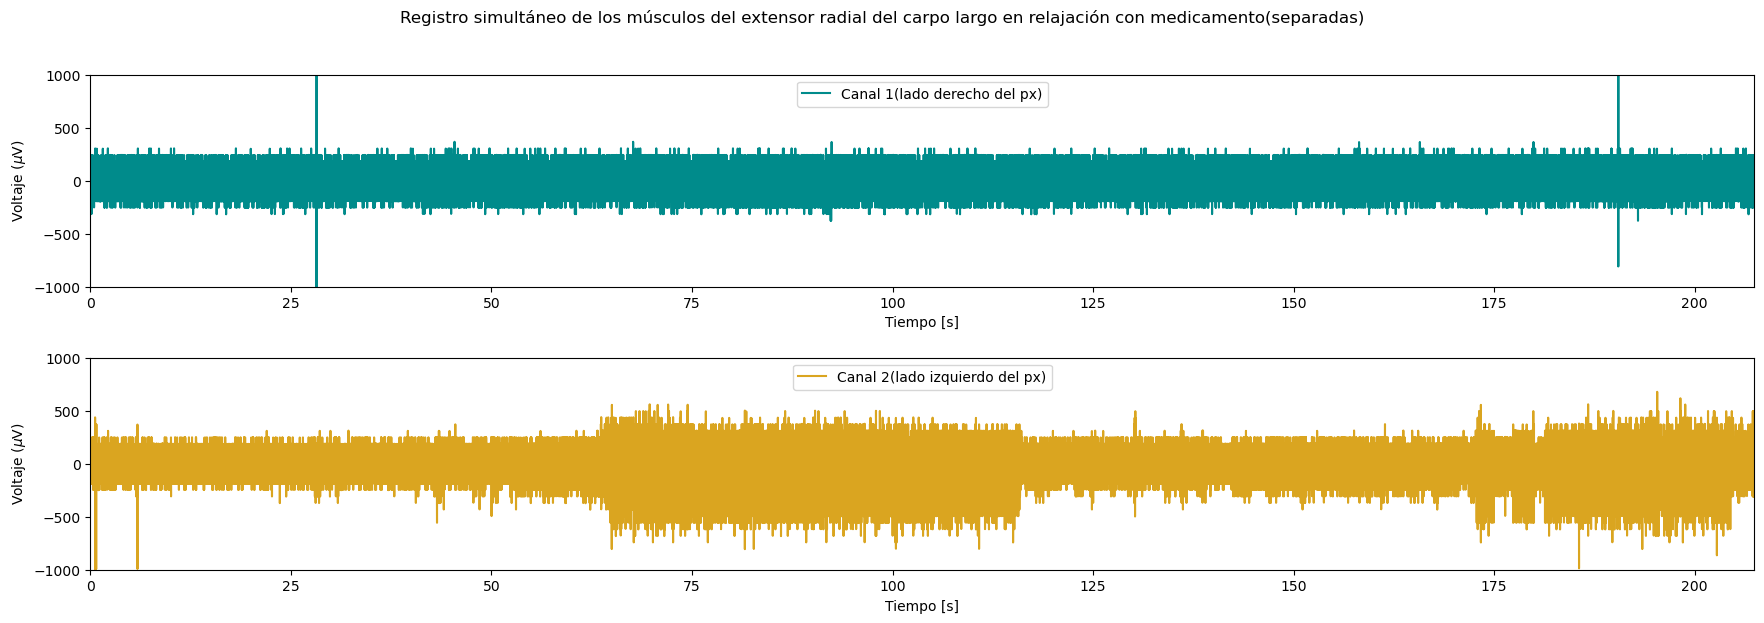

In [2]:
Folder="../Parkinson Notebooks/1-Registros-EMG/"    #Ubicar el folder donde se encuentra nuestro registro de EMG
rate,fileData=scipy.io.wavfile.read("../Parkinson Notebooks/1-Registros-EMG/Con medicamento/CM_Registro_FlexorLargo_Relajación.wav") #Abrir nuestro archivo wav

#Imprimimos los datos que nos van a funcionar para graficar ambos canales.
print("Número de canales (estéreo o mono) : "+str(fileData.shape[1])) 
print("Longitud de onda en segundos "+str(fileData.shape[0] / rate))

#wav Número de canales 
channel1=fileData[:,0]                                      #Izquierda
channel2=fileData[:,1]                                      #Derecha
N = fileData.shape[0]                                       #Número de datos/puntos
EMGtiempo = np.arange(0, float(fileData.shape[0]), 1)/rate  #creamos una variable de tiempo en segundos 
print(EMGtiempo)

frec = 1/np.mean(np.diff(EMGtiempo))

#Graficamos EMG
plt.figure(figsize=(18,6))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento')

#Graficamos en conjunto

plt.plot(EMGtiempo,channel1, color='darkcyan',label="Canal 1(lado derecho del px)")
plt.plot(EMGtiempo,channel2, color='goldenrod',label="Canal 2(lado izquierdo del px)")
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje ($\mu$V)')
plt.ylim(-1000,1000)
plt.xlim(0,max(EMGtiempo))
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.show()

#Graficamos EMG
plt.figure(figsize=(18,6))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas)')

#Graficamos canal 1
plt.subplot(211)
plt.xlim(0,max(EMGtiempo))
plt.ylim(-1000,1000)
plt.plot(EMGtiempo, channel1, color='darkcyan',label="Canal 1(lado derecho del px)")
plt.legend(loc="upper center", bbox_to_anchor=[0.5, 1],ncol=2, fontsize="medium")
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje ($\mu$V)')

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

#Graficamos canal 2
plt.subplot(212)
plt.xlim(0,max(EMGtiempo))
plt.ylim(-1000,1000)
plt.plot(EMGtiempo, channel2, color='goldenrod',label="Canal 2(lado izquierdo del px)")
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje ($\mu$V)')
plt.legend(loc="upper center", bbox_to_anchor=[0.5, 1],ncol=2, fontsize="medium")
plt.show()

<a id='3'></a>
# Filtración de las grabaciones.

La señal proveniente del registro puede tener ruido experimental o ambiental, por esta razón las grabaciones de EMG-Parkinson deben de ser filtradas para evitar que tengamos un análisis erróneo. El uso del $ filtro\ de\ paso\ banda $ es de uso común ya que conserva las frecuencias dentro del rango especificado y excluye las frecuencias fuera del rango. Las siguientes funciones se utilizan para pasar nuestros datos sin procesar a través de un filtro de paso de banda a 10-400 Hz[se usa para señales biológicas]. El $filtrado\ de\ Wiener$ se puede utilizar para tareas de separación y eliminación de ruido o interferencia de la fuente de audio. $Filtro\ Savitzky\ Golay$ permite suavizar los datos, no distorsionan la tendencia de la señal, en este filtro se pueden dar estimaciones de suavización de la señal o derivados de la señal suavizada mediante los subconjuntos.

<a id='4'></a>
## Filtro Butterworth de paso banda.

EL filtro Butterworth pasa bajas proporciona una respuesta en frecuencia plana en la banda de paso, la ventaja de usar el filtro de Butterworth es que mantiene su forma para órdenes mayores. El filtro pasa bajo de primer orden, el cual se puede modificar a un filtro o transformarlo a un filtro pasa banda o elimina banda.

In [3]:
# Filtro Butterworth de paso banda a 10-400Hz.
b, a = butter(2, ([10, 400]/(frec/2)), btype = 'bandpass')
#[b, a] = butter (n, Wn, ftype) diseña un filtro Butterworth de paso bajo, paso alto, paso banda o supresión de banda.
#La señal depende del valor de ftype y el número de elementos de Wn.
 
dataf1 = filtfilt(b, a, channel1)
dataf2 = filtfilt(b, a, channel2)

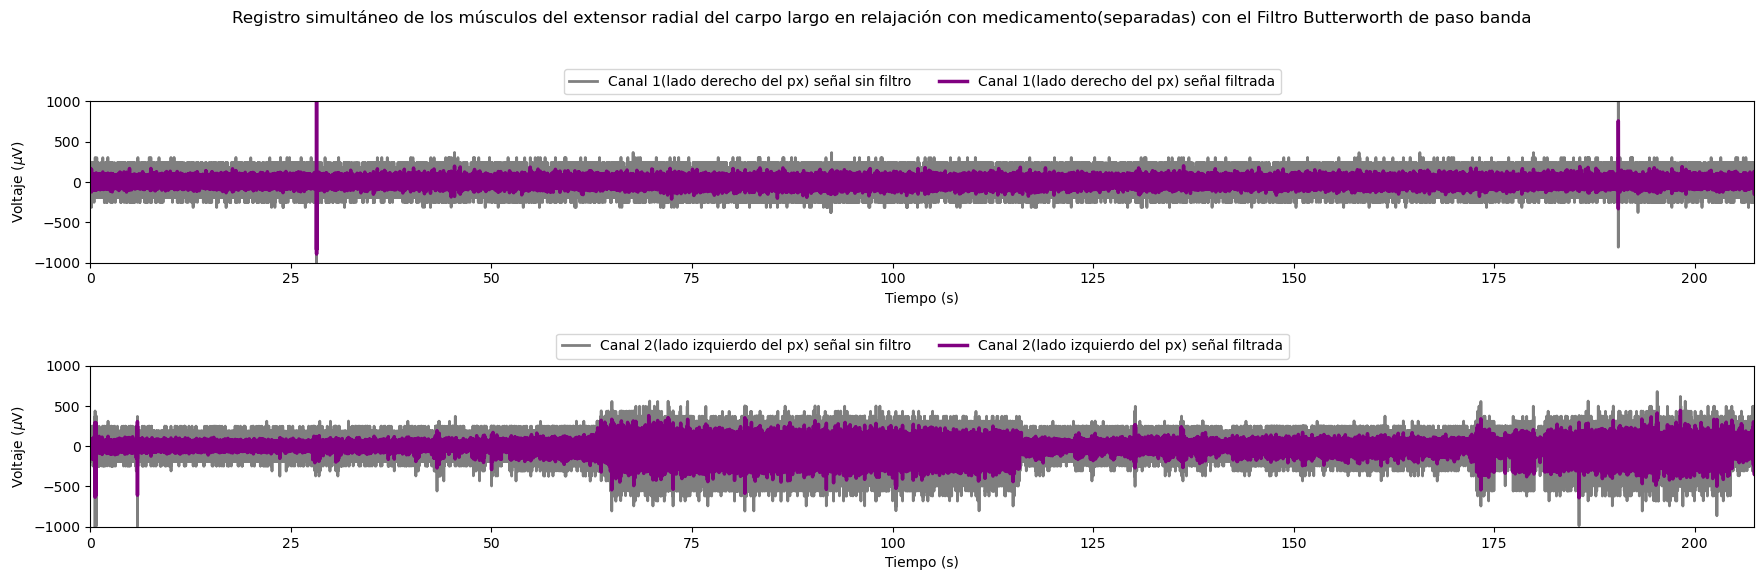

In [4]:
#Graficamos EMG
plt.figure(figsize=(18,6))                                                #Tamaño de la figura dibujada con Matplotlib
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas) con el Filtro Butterworth de paso banda')

plt.subplot(211)
plt.plot(EMGtiempo,channel1, 'black', linewidth=2.0, alpha=0.5,label="Canal 1(lado derecho del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf1, 'purple', linewidth=2.5,label="Canal 1(lado derecho del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(0,max(EMGtiempo))                                                #Eje x
plt.ylim(-1000,1000);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                 #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

plt.subplot(212)
plt.plot(EMGtiempo,channel2, 'black', linewidth=2.0, alpha=0.5,label="Canal 2(lado izquierdo del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf2, 'purple', linewidth=2.5,label="Canal 2(lado izquierdo del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(0,max(EMGtiempo))                                                #Eje x
plt.ylim(-1000,1000);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                  #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

### Ampliamos la ventana de visualización en el eje X (tiempo)

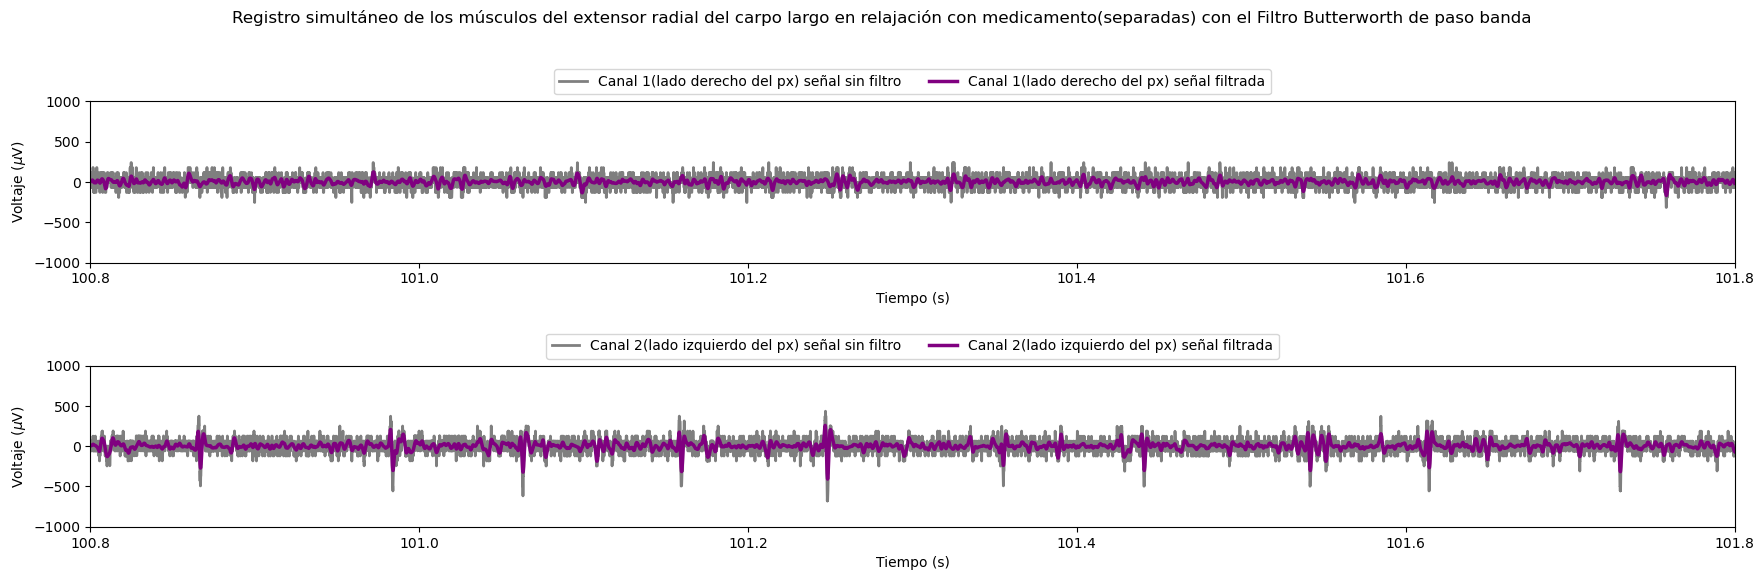

In [6]:
#Graficamos EMG
plt.figure(figsize=(18,6))                                                #Tamaño de la figura dibujada con Matplotlib
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas) con el Filtro Butterworth de paso banda')

plt.subplot(211)
plt.plot(EMGtiempo,channel1, 'black', linewidth=2.0, alpha=0.5,label="Canal 1(lado derecho del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf1, 'purple', linewidth=2.5,label="Canal 1(lado derecho del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(100.8,101.8)                                                           #Eje x
plt.ylim(-1000,1000);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                 #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

plt.subplot(212)
plt.plot(EMGtiempo,channel2, 'black', linewidth=2.0, alpha=0.5,label="Canal 2(lado izquierdo del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf2, 'purple', linewidth=2.5,label="Canal 2(lado izquierdo del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(100.8,101.8)                                                           #Eje x
plt.ylim(-1000,1000);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                  #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

Text(0, 0.5, 'Voltaje ($\\mu$V)')

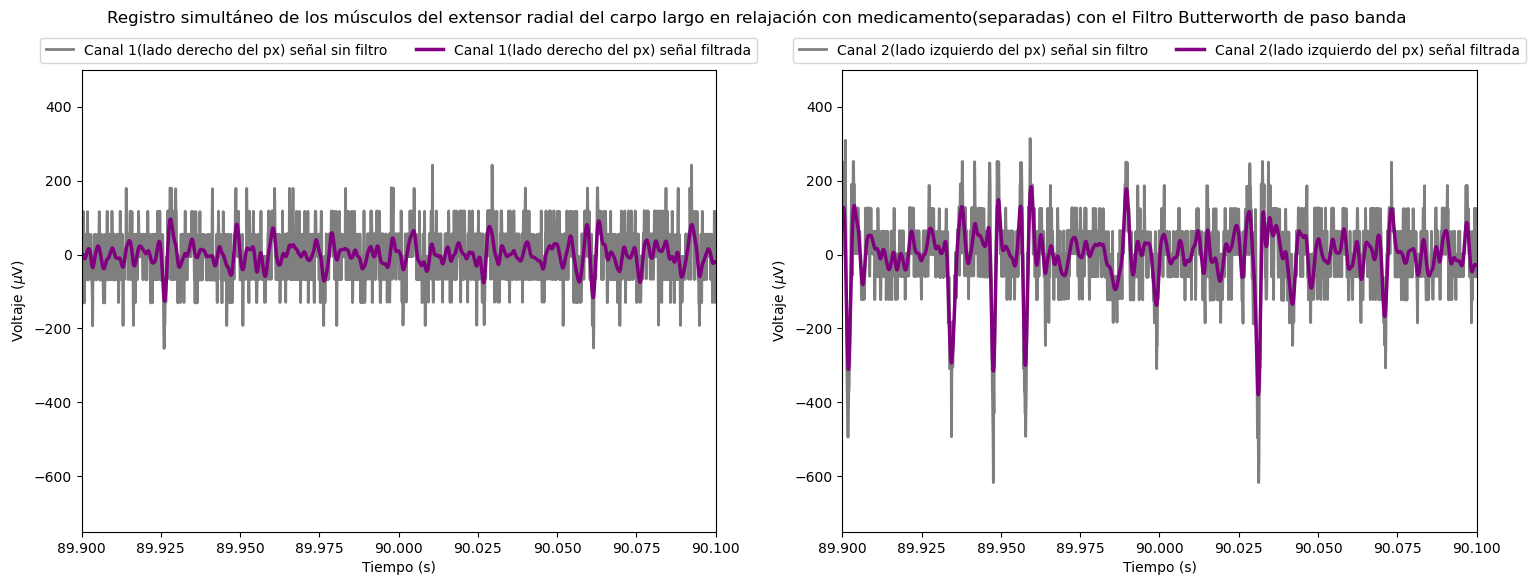

In [9]:
#Graficamos EMG
plt.figure(figsize=(18,6))                                                #Tamaño de la figura dibujada con Matplotlib
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas) con el Filtro Butterworth de paso banda')

plt.subplot(121)
plt.plot(EMGtiempo,channel1, 'black', linewidth=2.0, alpha=0.5,label="Canal 1(lado derecho del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf1, 'purple', linewidth=2.5,label="Canal 1(lado derecho del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(89.9,90.1)                                                           #Eje x
plt.ylim(-750,500);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                 #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

plt.subplot(122)
plt.plot(EMGtiempo,channel2, 'black', linewidth=2.0, alpha=0.5,label="Canal 2(lado izquierdo del px) señal sin filtro")           #Trazo de la señal con color.
plt.plot(EMGtiempo,dataf2, 'purple', linewidth=2.5,label="Canal 2(lado izquierdo del px) señal filtrada")                       #Trazo de la señal con color.
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
plt.xlim(89.9,90.1)                                                           #Eje x
plt.ylim(-750,500);                                                     #Eje y
plt.xlabel('Tiempo (s)')                                                  #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                            #Título del eje vertical.

Ampliando la ventana de tiempo, observamos las grabaciones sin procesar (negra) y filtradas (púrpura) superpuestas, podemos ver los resultados del filtrado de paso de banda, estableciendo límites podemos enfocarnos cercanamente en ver el resultado del filtrado de la señal.

#### En las siguientes gráficas podemos trazar una ventana de tiempo más grande para visualizar el filtrado de la señal, separamos las señales en dos gráficas diferentes.

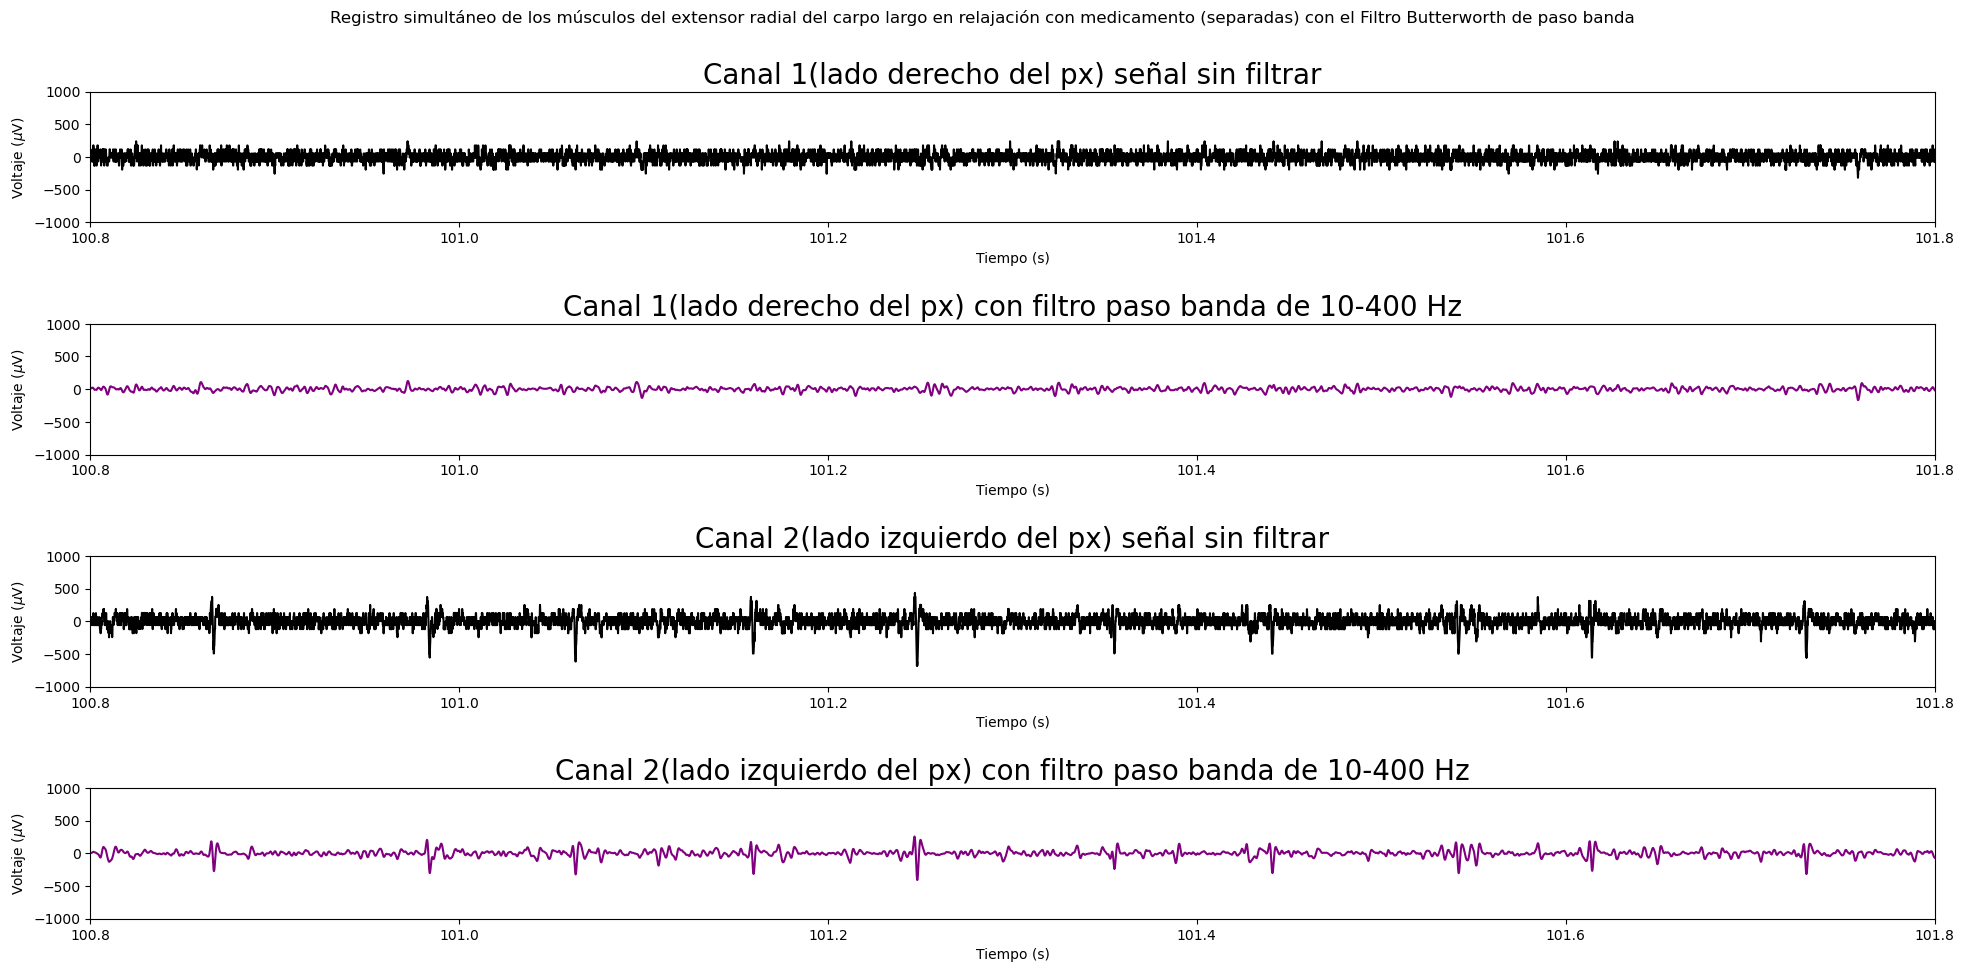

In [11]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, sharex= False, sharey= True, figsize = (20,10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento (separadas) con el Filtro Butterworth de paso banda')

# Trazar datos sin procesar
ax1.plot(EMGtiempo,channel1 , 'black')
ax1.set_title('Canal 1(lado derecho del px) señal sin filtrar', fontsize=20)
ax1.set_xlim(100.8,101.8)                                                
ax1.set_ylim(-1000,1000)
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')

# Trazar datos filtrados
ax2.plot(EMGtiempo, dataf1, 'purple')
ax2.set_title('Canal 1(lado derecho del px) con filtro paso banda de 10-400 Hz', fontsize=20)
ax2.set_xlim(100.8,101.8)
ax2.set_ylim(-1000,1000)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')

# Trazar datos sin procesar
ax3.plot(EMGtiempo,channel2 , 'black')
ax3.set_title('Canal 2(lado izquierdo del px) señal sin filtrar', fontsize=20)
ax3.set_xlim(100.8,101.8)                                               
ax3.set_ylim(-1000,1000)
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Voltaje ($\mu$V)')

# Trazar datos filtrados
ax4.plot(EMGtiempo, dataf2, 'purple')
ax4.set_title('Canal 2(lado izquierdo del px) con filtro paso banda de 10-400 Hz', fontsize=20)
ax4.set_xlim(100.8,101.8)
ax4.set_ylim(-1000,1000)
ax4.set_xlabel('Tiempo (s)')
ax4.set_ylabel('Voltaje ($\mu$V)')

 
# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

<a id='5'></a>
## Valor absoluto de EMG.

Para este análisis, se rectificó la señal electromiografia de modo que terminemos trabajando con valores de voltaje positivos, esto permitirá posteriormente calcular una envolvente y establecer un umbral para la detección de contracciones.

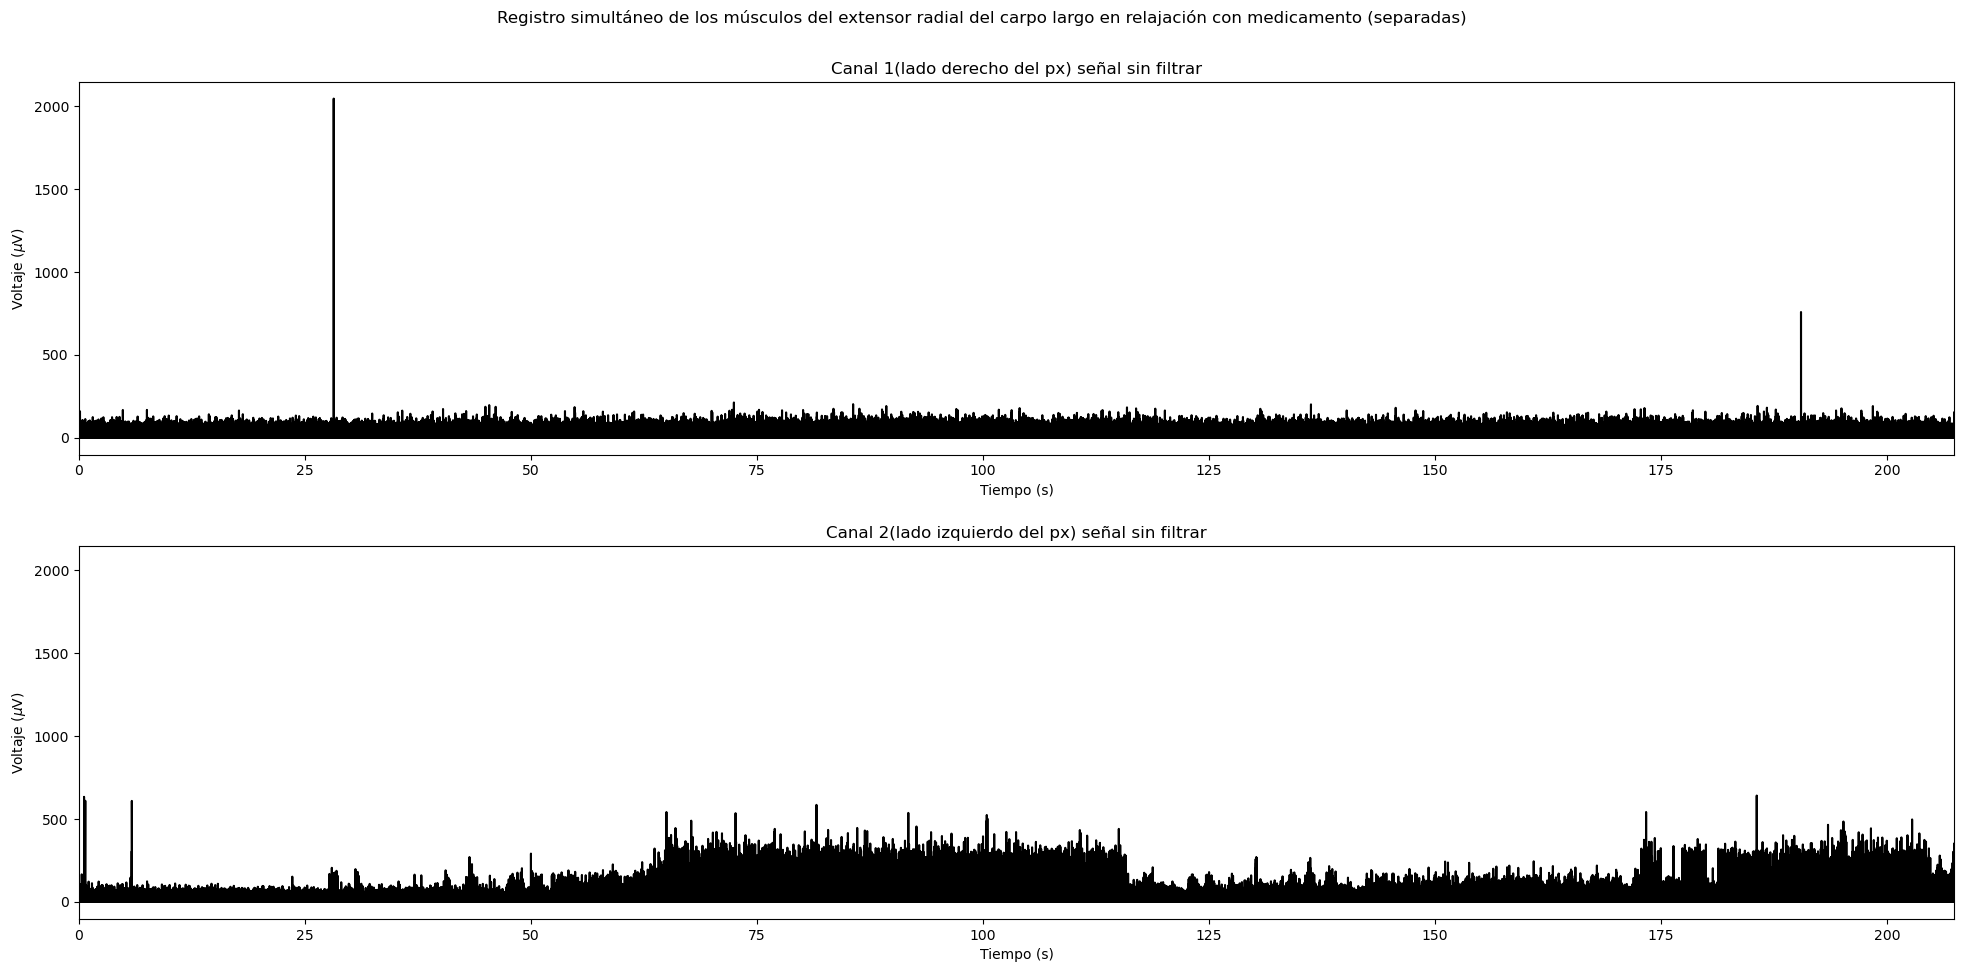

In [12]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex= False, sharey= True, figsize = (20,10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento (separadas)')
# Rectificar la señal EMG
AbsSeñal1 = np.absolute(dataf1)                                                          #Calcula el valor absoluto por elementos.
AbsSeñal2 = np.absolute(dataf2) 
Abstiempo1=np.linspace(0, len(AbsSeñal1), num=len(AbsSeñal1))
Abstiempo2=np.linspace(0, len(AbsSeñal2), num=len(AbsSeñal2))

# Trazar datos rectificados
ax1.set_title('Canal 1(lado derecho del px) señal sin filtrar') #Título.
ax1.set_xlabel('Tiempo (s)')                                                              #Título del eje horizontal.
ax1.set_ylabel('Voltaje ($\mu$V)')                                                        #Título del eje vertical.
ax1.plot(EMGtiempo,AbsSeñal1,'black')                                                   #Graficación y color de la señal.
ax1.set_xlim(0,max(EMGtiempo))

# Trazar datos rectificados                                                            
ax2.set_title('Canal 2(lado izquierdo del px) señal sin filtrar') #Título.
ax2.set_xlabel('Tiempo (s)')                                                              #Título del eje horizontal.
ax2.set_ylabel('Voltaje ($\mu$V)')                                                        #Título del eje vertical.
ax2.plot(EMGtiempo,AbsSeñal2,'black')                                                   #Graficación y color de la señal.
ax2.set_xlim(0,max(EMGtiempo))

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

<a id='6'></a>
## Análisis de registros mediante cuantificaciones.

Podemos determinar la envolvente de la señal rectificada. Una forma de hacerlo es aplicar un filtro Butterworth de paso bajo, en este caso con un corte de 8Hz.

#### ¿Por qué especificamos 8 Hz como corte de paso bajo?
Debido a que en las señales EMG se propagan en una frecuencia superior a 7 Hz.

In [13]:
# Filtro Butterworth de paso bajo para detección de envolvente
lowp = 8     
sfrec =1/np.mean(np.diff(EMGtiempo))
low_pass = lowp/sfrec
b, a = sc.signal.butter(4, low_pass, btype='lowpass')
datafrle1 = filtfilt(b, a, AbsSeñal1)
datafrle2 = filtfilt(b, a, AbsSeñal2)

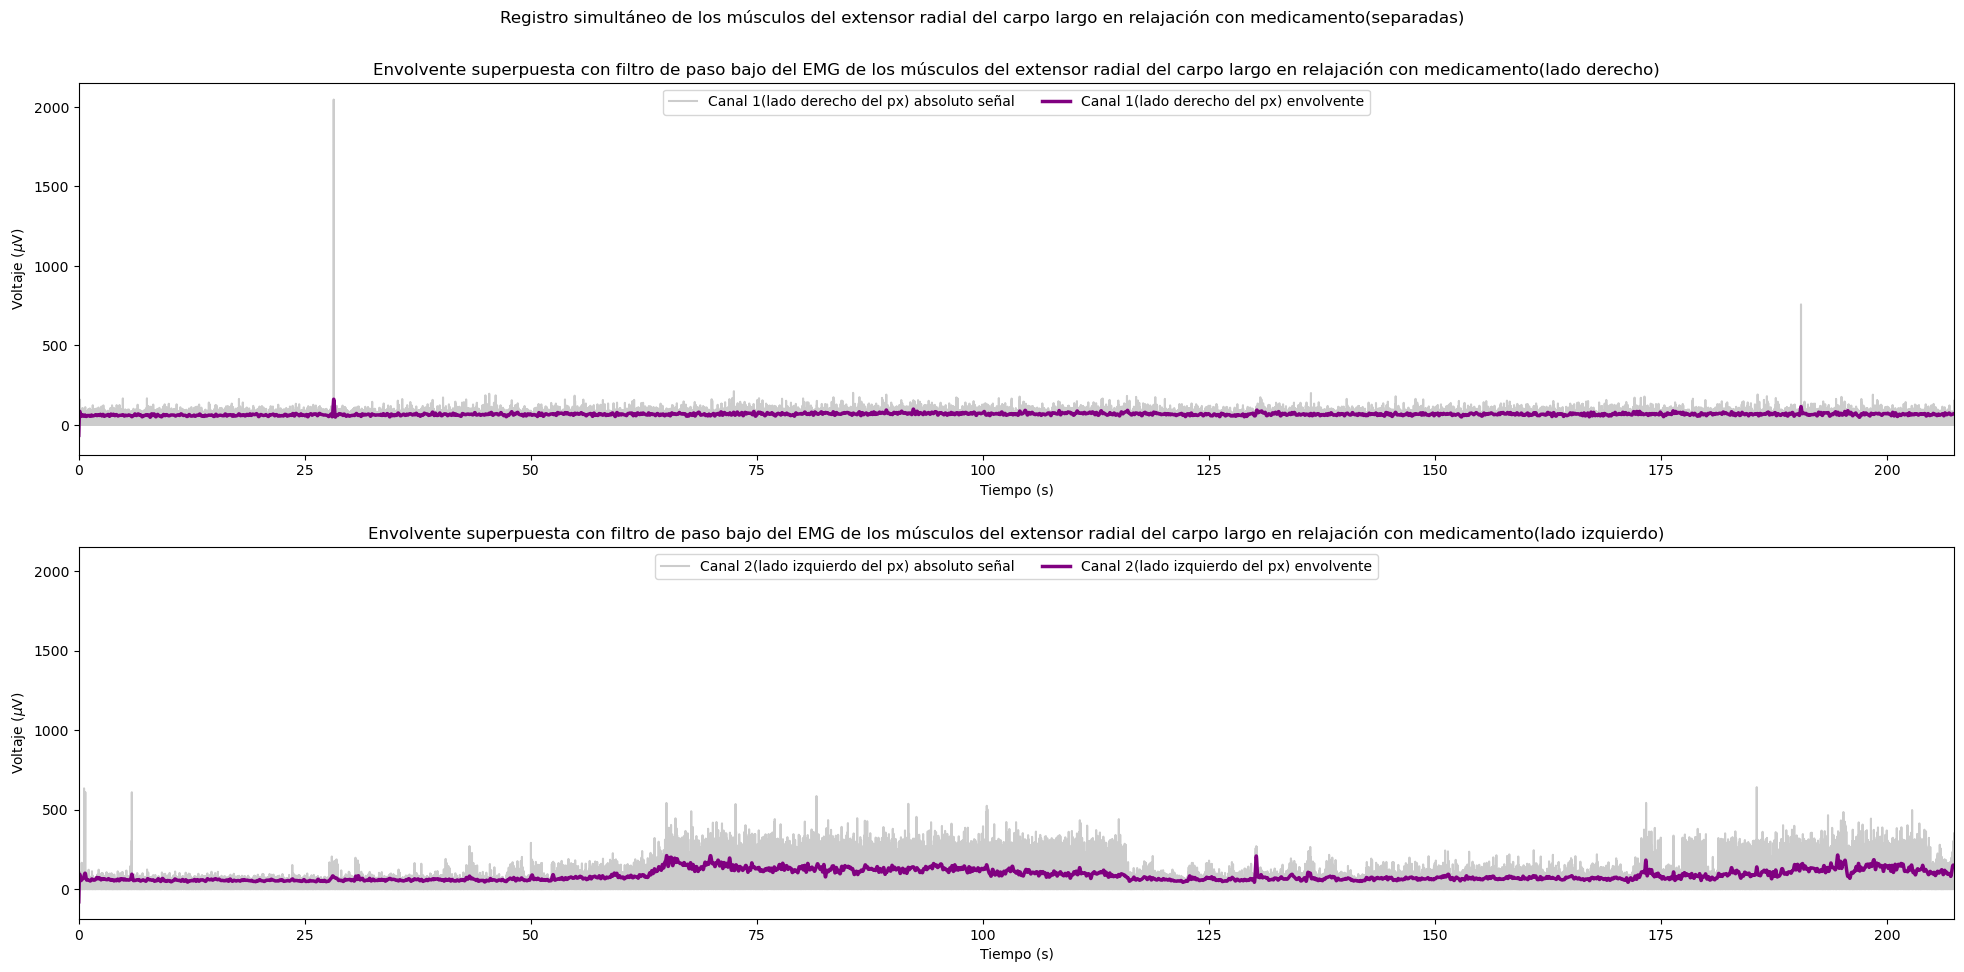

In [14]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex= False, sharey= True, figsize = (20,10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas)')

#Trazar señal EMG rectificada con detección de envolvente superpuesta con filtro de paso bajo
ax1.set_title('Envolvente superpuesta con filtro de paso bajo del EMG de los músculos del extensor radial del carpo largo en relajación con medicamento(lado derecho)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.plot(EMGtiempo,AbsSeñal1, 'gray', alpha=0.4,label="Canal 1(lado derecho del px) absoluto señal")
ax1.plot(EMGtiempo,datafrle1*3, 'purple', linewidth=2.5,label="Canal 1(lado derecho del px) envolvente") 
ax1.legend(loc="upper center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
ax1.set_xlim(0,max(EMGtiempo))

#Trazar señal EMG rectificada con detección de envolvente superpuesta con filtro de paso bajo
ax2.set_title('Envolvente superpuesta con filtro de paso bajo del EMG de los músculos del extensor radial del carpo largo en relajación con medicamento(lado izquierdo)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')
ax2.plot(EMGtiempo,AbsSeñal2, 'gray', alpha=0.4, label="Canal 2(lado izquierdo del px) absoluto señal")
ax2.plot(EMGtiempo,datafrle2*3, 'purple', linewidth=2.5,label="Canal 2(lado izquierdo del px) envolvente")
ax2.legend(loc="upper center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
ax2.set_xlim(0,max(EMGtiempo))

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

La actividad muscular se puede registrar mediante la electromiografía, aunque también es útil conocer los tiempos de inicio y finalización de las contracciones, mediante la cuantificación de las duraciones de las contracciones nos permitirá entender las variaciones de las grabaciones, estas cuantificaciones ayudarán a conocer si las contracciones tienen la misma duración o ver cuánto varían en una grabación.

### $Detección\ de\ los\ tiempos\ de\ inicio\ y\ finalización\ de\ la\ contracción\ muscular$
Si trazamos la envolvente del EMG (sin la señal con ruido experimental), podemos estimar el valor apropiado para utilizarlo como umbral para detectar los tiempos de inicio y finalización de la contracción muscular. Con un valor lo suficientemente bajo que incluya la mayor parte de la contracción, pero lo suficientemente grande como para descartar el ruido y las pequeñas contracciones musculares. Para la envolvente trazada a continuación, aplicamos un umbral con valor de 35.

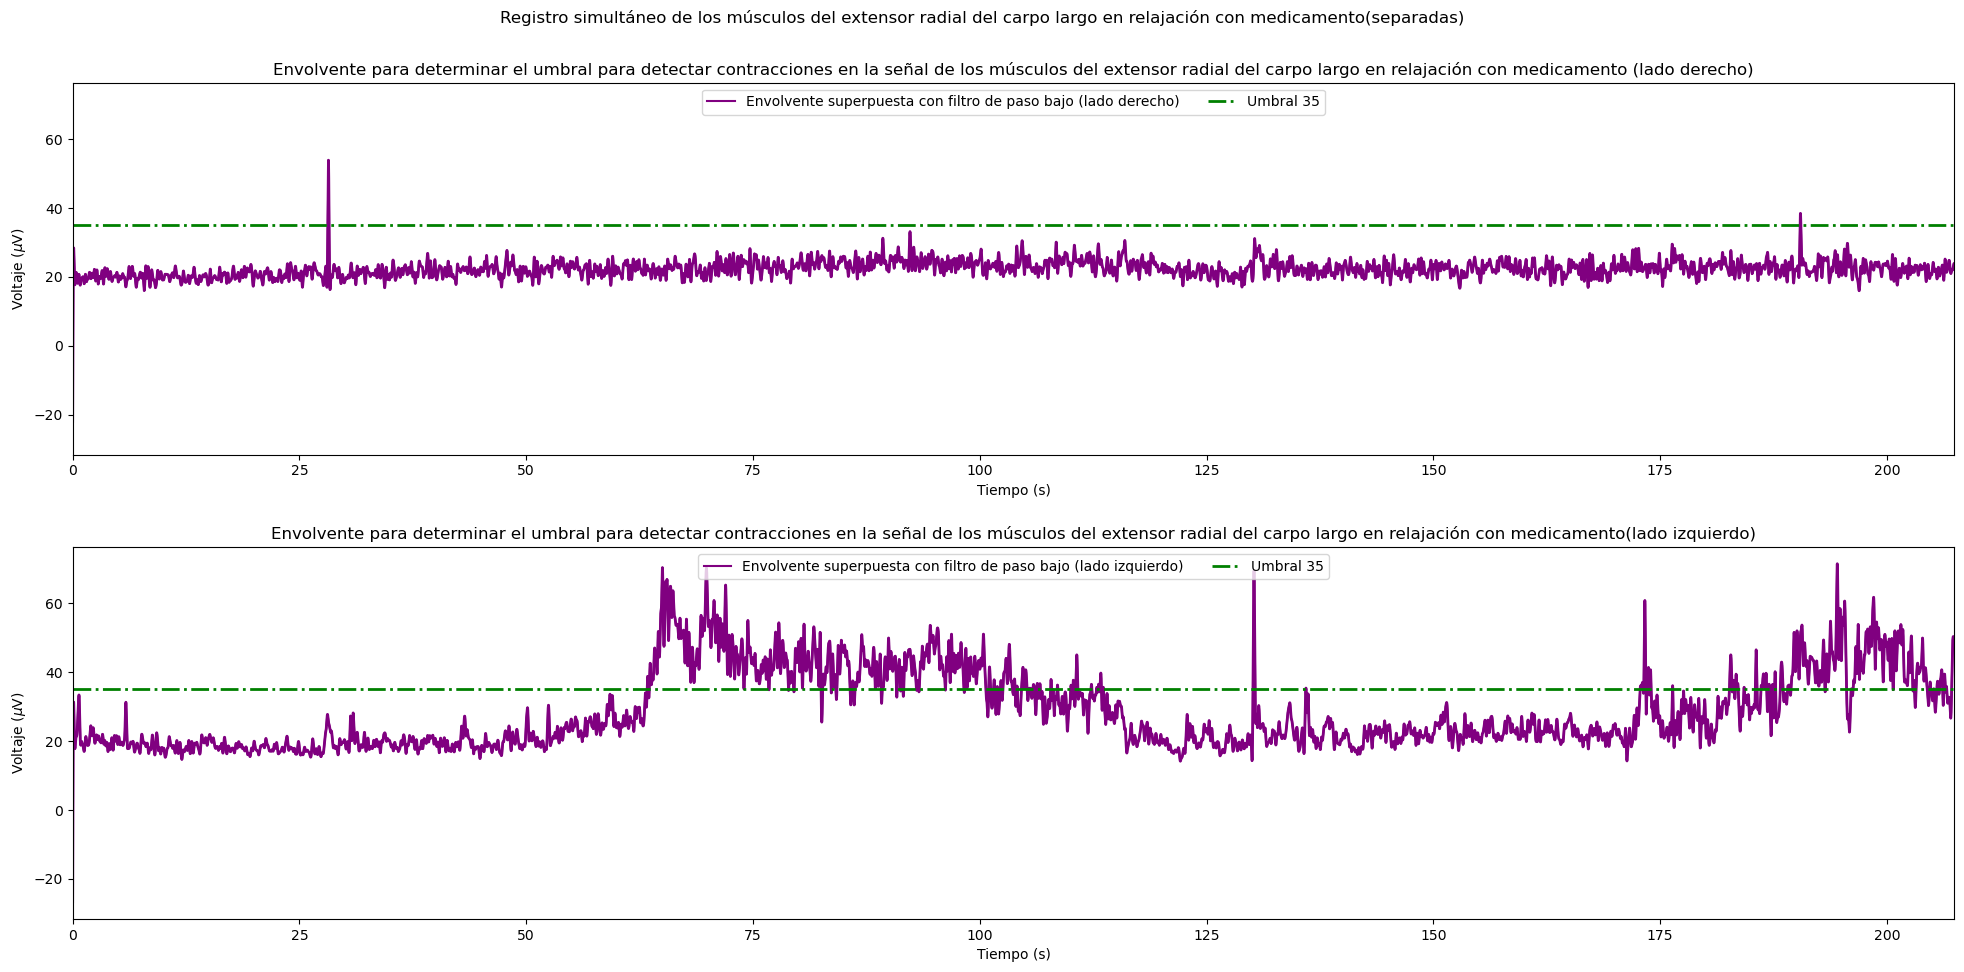

In [16]:
#Antes de trazar esta envolvente es necesario solo correr la 'Envolvente superpuesta con filtro de paso bajo del EMG del músculo
#de pantorrilla durante elevaciones repetidas con una frecuencia de corte superior a 8 Hz, o la ideal para trabajar.
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex= False, sharey= True, figsize = (20,10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas)')

#Trazar solo la envolvente para determinar el umbral para detectar contracciones
#ax1.set_figure(figsize=(18,6))
ax1.set_title('Envolvente para determinar el umbral para detectar contracciones en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento (lado derecho)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.plot(EMGtiempo,datafrle1, 'purple', linewidth=2.0)
ax1.plot(EMGtiempo,datafrle1, 'purple', label = "Envolvente superpuesta con filtro de paso bajo (lado derecho)")
ax1.axhline(y=35, color='green',linewidth=2.0, linestyle='-.', label = "Umbral 35") #Umbral potencial
ax1.legend(loc="upper center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
ax1.set_xlim(0,max(EMGtiempo))

#Trazar solo la envolvente para determinar el umbral para detectar contracciones
#ax2.set_figure(figsize=(18,6))
ax2.set_title('Envolvente para determinar el umbral para detectar contracciones en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado izquierdo)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')
ax2.plot(EMGtiempo,datafrle2, 'purple', linewidth=2.0)
ax2.plot(EMGtiempo,datafrle2, 'purple', label = "Envolvente superpuesta con filtro de paso bajo (lado izquierdo)")
ax2.axhline(y=35, color='green',linewidth=2.0, linestyle='-.', label = "Umbral 35") #Umbral potencial
ax2.legend(loc="upper center", bbox_to_anchor=[0.5, 1], ncol=2, fontsize="medium")
ax2.set_xlim(0,max(EMGtiempo))

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

Luego, podemos usar nuestro umbral para detectar los tiempos de inicio y finalización de la contracción, en el momento de inicio, queremos los índices donde el valor de la señal es igual o mayor que el umbral cuando el valor anterior estaba por debajo del umbral, es decir, el cruce del umbral ascendente (el tiempo que nos dará será en horas, posteriormente lo cambiaremos a segundos).

### $Umbral\ para\ detectar\ los\ tiempos\ de\ inicio.$

In [17]:
threshold = 35 #Umbral
cstarts1= [] #Tiempos de inicio 
for i in range(1, len(datafrle1)):
    if datafrle1[i-1] < threshold and datafrle1[i] >= threshold:
        cstarts1.append(i)
print('Tiempo de inicio del umbral del canal 1 (lado derecho):')       
print(cstarts1) 

cstarts2= [] #Tiempos de inicio 
for i in range(1, len(datafrle2)):
    if datafrle2[i-1] < threshold and datafrle2[i] >= threshold:
        cstarts2.append(i)
print('Tiempo de inicio del umbral del canal 2 (lado izquierdo):')       
print(cstarts2)

Tiempo de inicio del umbral del canal 1 (lado derecho):
[281228, 1904307]
Tiempo de inicio del umbral del canal 2 (lado izquierdo):
[633283, 635701, 767758, 789395, 795429, 826815, 836644, 842564, 859012, 862444, 892539, 909014, 913034, 916228, 930672, 933293, 962241, 983336, 1009859, 1015193, 1019101, 1022636, 1025452, 1037637, 1040748, 1045951, 1054281, 1058472, 1062902, 1065743, 1077980, 1085168, 1100222, 1102489, 1105731, 1122507, 1128714, 1130443, 1132480, 1135870, 1301193, 1359424, 1727964, 1731942, 1735631, 1738735, 1763576, 1826452, 1830015, 1832994, 1842354, 1854980, 1861113, 1869662, 1873678, 1876213, 1882491, 1890495, 1894314, 1932216, 1960666, 1962775, 2007070, 2029111, 2032224, 2047108, 2051662, 2055034, 2057994, 2062916, 2065246, 2071403]


### $Umbral\ para\ detectar\ los\ tiempos\ de\ finalización.$ 

In [18]:
threshold = 35 #Umbral
cstops1 = [] #Tiempos de finaclización
for i in range(1, len(datafrle1)):
    if datafrle1[i-1] >= threshold and datafrle1[i] < threshold:
        cstops1.append(i)
print('Tiempo de finalización del umbral del canal 1 (lado derecho):')         
print(cstops1)

cstops2 = [] #Tiempos de finaclización
for i in range(1, len(datafrle2)):
    if datafrle2[i-1] >= threshold and datafrle2[i] < threshold:
        cstops2.append(i)
print('Tiempo de finalización del umbral del canal 2 (lado izquierdo):')         
print(cstops2)

Tiempo de finalización del umbral del canal 1 (lado derecho):
[282741, 1905195]
Tiempo de finalización del umbral del canal 2 (lado izquierdo):
[634556, 767472, 789031, 794842, 825057, 836086, 841188, 856922, 860766, 891194, 908125, 912559, 915272, 930163, 932579, 961936, 982539, 1006613, 1011975, 1016562, 1019642, 1024062, 1036000, 1038974, 1041396, 1052115, 1056245, 1060428, 1064122, 1066847, 1079143, 1086139, 1101076, 1103797, 1108145, 1123661, 1129481, 1131700, 1134162, 1136383, 1303497, 1359771, 1731322, 1734194, 1738037, 1740129, 1764049, 1829375, 1831702, 1836152, 1842915, 1856845, 1867534, 1870651, 1874321, 1877428, 1885504, 1893023, 1931708, 1955579, 1960993, 2006877, 2028634, 2030470, 2044559, 2048440, 2051964, 2056828, 2061415, 2064522, 2066045]


Luego dividimos los tiempos de inicio y finalización por la frecuencia de muestreo para obtener los $tiempos\ en\ segundos$.

In [19]:
#Canal 1 (derecho)
starts1=[]
for n in range(0, len(cstarts1)):
    starttime = cstarts1[n]/(1/np.mean(np.diff(EMGtiempo)))
    starts1.append(starttime)
print('Inicio:')     
print(starts1)

#Canal 1 (derecho)
stops1=[]
for n in range(0, len(cstops1)):
    stoptime = cstops1[n]/(1/np.mean(np.diff(EMGtiempo)))
    stops1.append(stoptime)
print('Final:')     
print(stops1)

#Canal 2(izquierdo)
starts2=[]
for n in range(0, len(cstarts2)):
    starttime = cstarts2[n]/(1/np.mean(np.diff(EMGtiempo)))
    starts2.append(starttime)
print('Inicio:')     
print(starts2)

#Canal 2(izquierdo)
stops2=[]
for n in range(0, len(cstops2)):
    stoptime = cstops2[n]/(1/np.mean(np.diff(EMGtiempo)))
    stops2.append(stoptime)
print('Final:')     
print(stops2)

Inicio:
[28.1228, 190.4307]
Final:
[28.2741, 190.5195]
Inicio:
[63.3283, 63.5701, 76.7758, 78.9395, 79.5429, 82.6815, 83.6644, 84.2564, 85.9012, 86.2444, 89.2539, 90.9014, 91.3034, 91.6228, 93.0672, 93.3293, 96.2241, 98.3336, 100.9859, 101.5193, 101.9101, 102.2636, 102.5452, 103.7637, 104.0748, 104.5951, 105.4281, 105.8472, 106.2902, 106.5743, 107.798, 108.5168, 110.0222, 110.2489, 110.5731, 112.2507, 112.8714, 113.0443, 113.248, 113.587, 130.1193, 135.9424, 172.7964, 173.1942, 173.5631, 173.8735, 176.3576, 182.6452, 183.0015, 183.2994, 184.2354, 185.498, 186.1113, 186.9662, 187.3678, 187.6213, 188.2491, 189.0495, 189.4314, 193.2216, 196.0666, 196.2775, 200.707, 202.9111, 203.2224, 204.7108, 205.1662, 205.5034, 205.7994, 206.2916, 206.5246, 207.1403]
Final:
[63.4556, 76.7472, 78.9031, 79.4842, 82.5057, 83.6086, 84.1188, 85.6922, 86.0766, 89.1194, 90.8125, 91.2559, 91.5272, 93.0163, 93.2579, 96.1936, 98.2539, 100.6613, 101.1975, 101.6562, 101.9642, 102.4062, 103.6, 103.8974, 104.1396, 1

Para ver qué tan bien funciona nuestra detección de eventos, trazamos la envoltura de la señal EMG y luego trazamos los tiempos de inicio y finalización con líneas discontinuas. Podemos volver atrás y ajustar el umbral dependiendo de si queremos capturar más o menos actividad muscular.

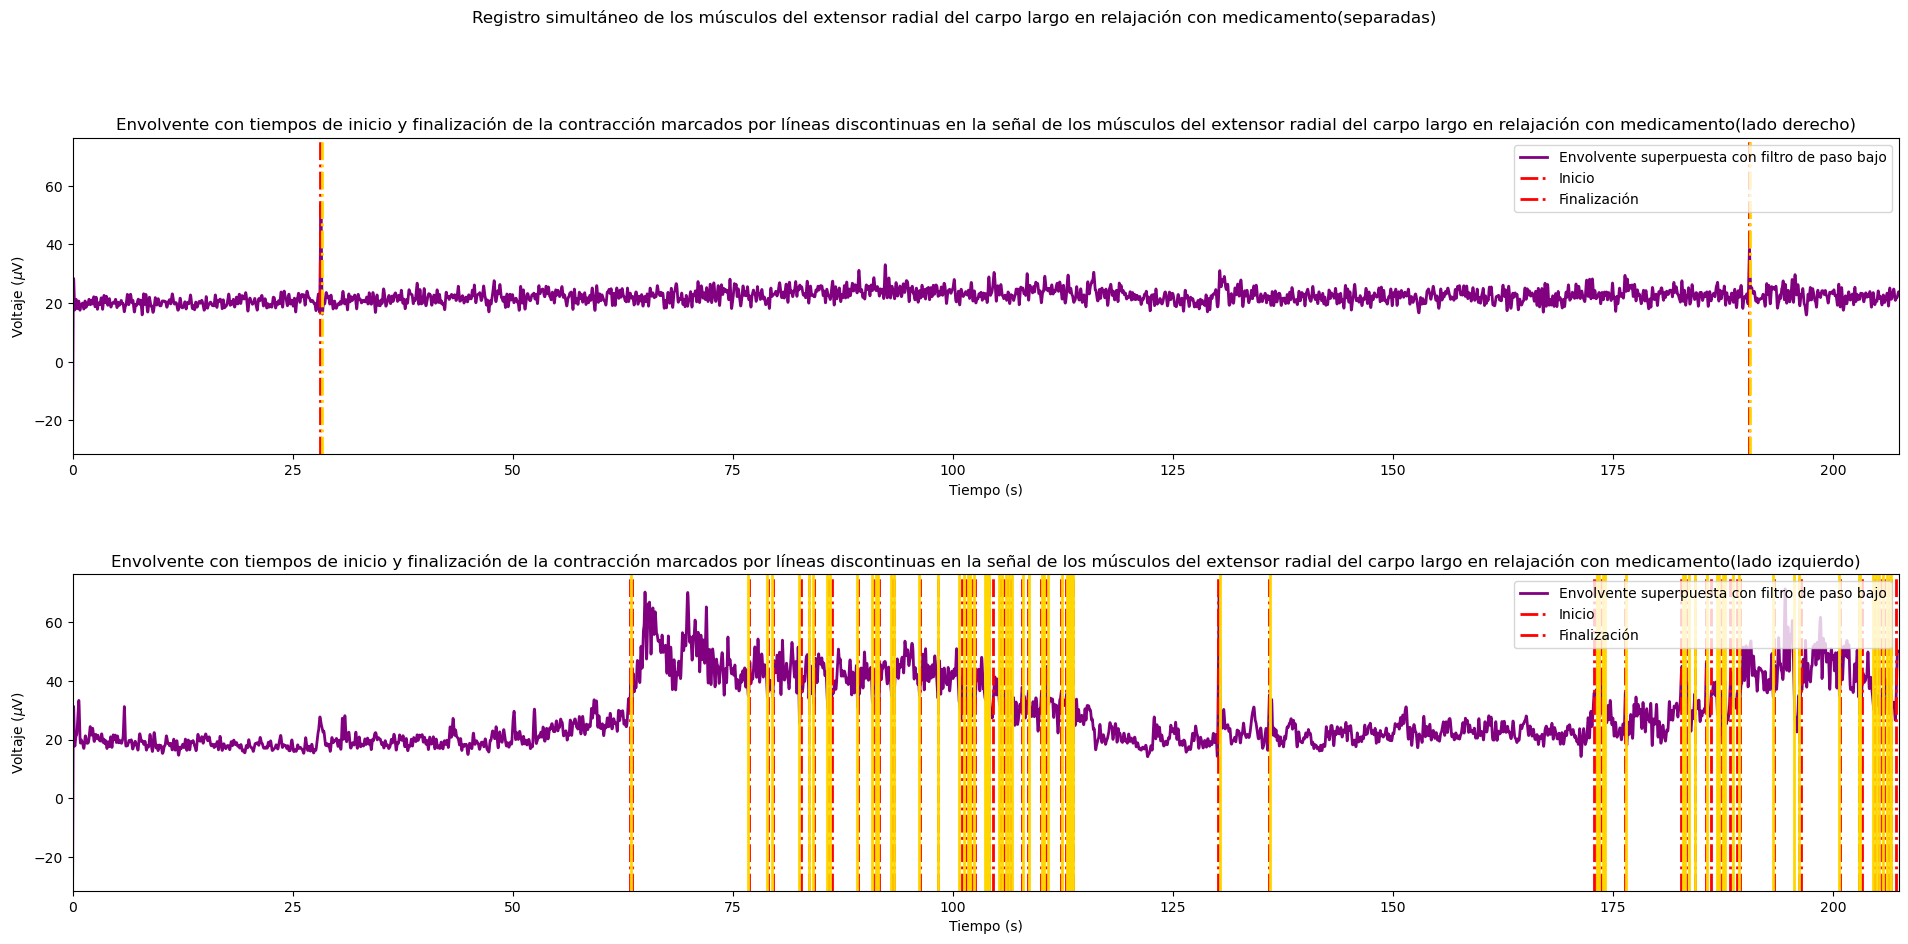

In [20]:
# Trazar envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=True, figsize=(20, 10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas)')

ax1.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado derecho)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.plot(EMGtiempo, datafrle1, 'purple', linewidth=2.0)
ax1.set_xlim(0, max(EMGtiempo))
# Para la detección de tiempo de inicio.
for n in range(0, len(starts1)):
    ax1.axvline(x=starts1[n], color='red', linewidth=2.0, linestyle='-.')
# Para la detección de tiempo de finalización.
for n in range(0, len(stops1)):
    ax1.axvline(x=stops1[n], color='gold', linewidth=2.0, linestyle='-.')

ax2.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado izquierdo)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')
ax2.plot(EMGtiempo, datafrle2, 'purple', linewidth=2.0)
ax2.set_xlim(0, max(EMGtiempo))
# Para la detección de tiempo de inicio.
for n in range(0, len(starts2)):
    ax2.axvline(x=starts2[n], color='red', linewidth=2.0, linestyle='-.')
# Para la detección de tiempo de finalización.
for n in range(0, len(stops2)):
    ax2.axvline(x=stops2[n], color='gold', linewidth=2.0, linestyle='-')

ax1.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='upper right')
ax2.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='upper right')

# Espaciado entre ventanas
plt.tight_layout(pad=4.0)


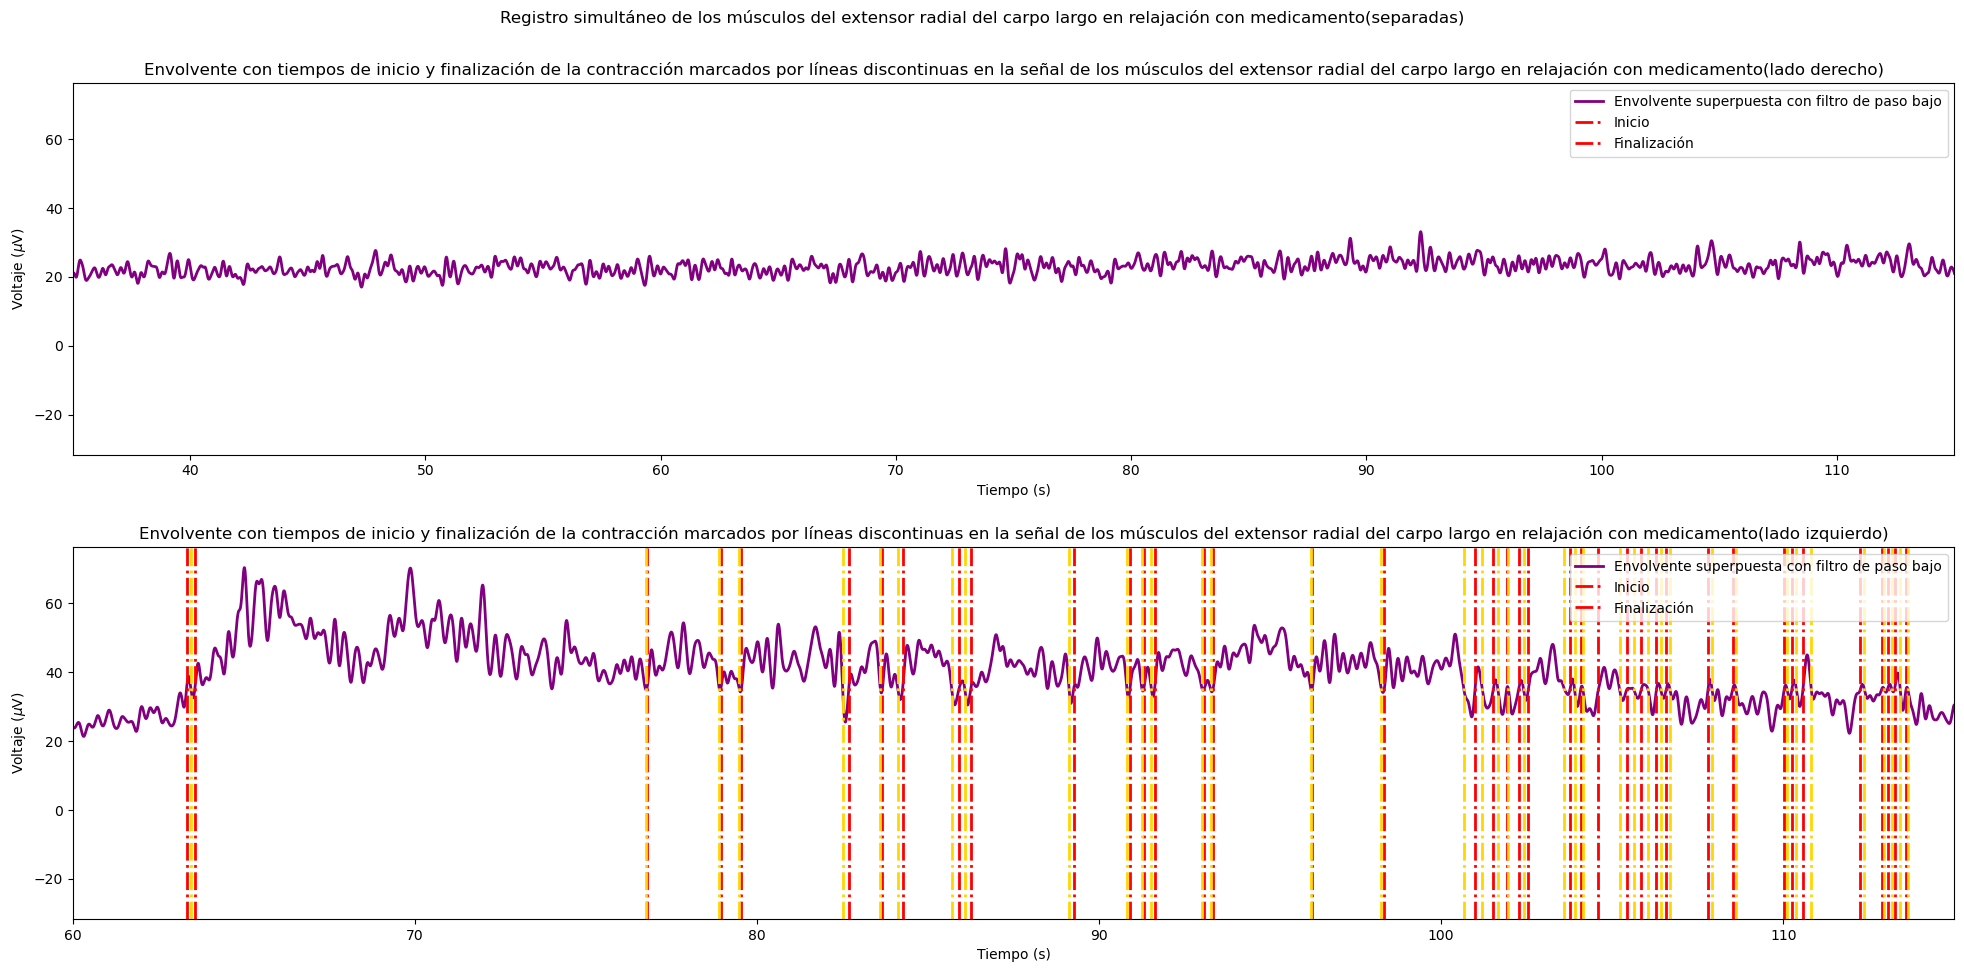

In [22]:
#Trazar envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex= False, sharey= True, figsize = (20,10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento(separadas)')

ax1.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado derecho)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.plot(EMGtiempo, datafrle1, 'purple', linewidth=2.0, label = "Envolvente superpuesta con filtro de paso bajo")
ax1.set_xlim(35,115);
#Para la detección de tiempo de inicio.
for n in range(0, len(starts1)):
    ax1.axvline(x=starts1[n], color='red',linewidth=2.0, linestyle='-.', label="Inicio")
    
#Para la detección de tiempo de finalización.    
for n in range(0, len(stops1)):
    ax1.axvline(x=stops1[n], color='gold',linewidth=2.0, linestyle='-.',label="Finalización")
    

ax2.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado izquierdo)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')
ax2.plot(EMGtiempo, datafrle2, 'purple', linewidth=2.0, label = "Envolvente superpuesta con filtro de paso bajo")
ax2.set_xlim(60,115);

#Para la detección de tiempo de inicio.
for n in range(0, len(starts2)):
    ax2.axvline(x=starts2[n], color='red',linewidth=2.0, linestyle='-.', label="Inicio")

#Para la detección de tiempo de finalización.    
for n in range(0, len(stops2)):
    ax2.axvline(x=stops2[n], color='gold',linewidth=2.0, linestyle='-.',label="Finalización")

ax1.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='upper right')
ax2.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='upper right')

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

Con el umbral seleccionado estamos detectando los tiempos de inicio y finalización de las contracciones, podemos ajustar el umbral si es necesario para mejorar la detección. Utilizando la diferencia entre los tiempos de inicio y finalización, podemos calcular la duración de cada contracción muscular.

*Las duraciones redondeadas a dos decimales, las unidades están en segundos.

In [23]:
#Calcular e imprimir las duraciones de las contracciones en segundos
durs1=[]
for n in range(0,len(starts1)):
    durs1.append(stops1[n]-starts1[n])
    print('Duración de las contracciones en segundos lado derecho:') 
    print(round(durs1[n], 4))
    
durs2=[]
for n in range(0,len(starts2)):
    durs2.append(stops2[n]-starts2[n])
    print('Duración de las contracciones en segundos lado izquierdo:') 
    print(round(durs2[n], 4))

Duración de las contracciones en segundos lado derecho:
0.1513
Duración de las contracciones en segundos lado derecho:
0.0888
Duración de las contracciones en segundos lado izquierdo:
0.1273
Duración de las contracciones en segundos lado izquierdo:
13.1771
Duración de las contracciones en segundos lado izquierdo:
2.1273
Duración de las contracciones en segundos lado izquierdo:
0.5447
Duración de las contracciones en segundos lado izquierdo:
2.9628
Duración de las contracciones en segundos lado izquierdo:
0.9271
Duración de las contracciones en segundos lado izquierdo:
0.4544
Duración de las contracciones en segundos lado izquierdo:
1.4358
Duración de las contracciones en segundos lado izquierdo:
0.1754
Duración de las contracciones en segundos lado izquierdo:
2.875
Duración de las contracciones en segundos lado izquierdo:
1.5586
Duración de las contracciones en segundos lado izquierdo:
0.3545
Duración de las contracciones en segundos lado izquierdo:
0.2238
Duración de las contracciones

IndexError: list index out of range

Comprobamos si tienen la misma longitud la listas.

In [24]:
# Asegúrate de que las listas starts1, stops1, starts2 y stops2 tengan los valores adecuados

durs1 = []
durs2 = []

# Verifica que ambas listas tengan la misma longitud antes de continuar
if len(starts1) == len(stops1) and len(starts2) == len(stops2):
    for n in range(len(starts1)):
        durs1.append(stops1[n] - starts1[n])
        print('Duración de las contracciones en segundos lado derecho:')
        print(round(durs1[n], 4))

        durs2.append(stops2[n] - starts2[n])
        print('Duración de las contracciones en segundos lado izquierdo:')
        print(round(durs2[n], 4))
else:
    print('Las listas no tienen la misma longitud, no se pueden calcular las duraciones.')

Las listas no tienen la misma longitud, no se pueden calcular las duraciones.


Elaboramos un programa más "automatizado", pero no es tan eficaz detectando la actividad, incluso solo detecta posibles artefactos o actividad inexistente.

Duración de las contracciones en segundos lado derecho:
[0.0466 0.1991 0.0843 0.0494 0.0749 0.0245 0.0455 0.0596 0.064  0.0754
 0.0395 0.1739 0.1326 0.1984 0.112  0.0251 0.1986 0.1095 0.0446 0.1146
 0.2246 0.1358 0.0721 0.1513 0.0625 0.1783 0.0591 0.3628 0.1706 0.366
 0.0982 0.1023 0.0903 0.0891 0.134  0.0942 0.0357 0.0645 0.0434 0.1928
 0.0671 0.0818 0.1491]
La detección de inicios y finales de contracciones en el lado izquierdo es inconsistente.
Duración de las contracciones en segundos lado derecho:
[0.0466 0.1991 0.0843 0.0494 0.0749 0.0245 0.0455 0.0596 0.064  0.0754
 0.0395 0.1739 0.1326 0.1984 0.112  0.0251 0.1986 0.1095 0.0446 0.1146
 0.2246 0.1358 0.0721 0.1513 0.0625 0.1783 0.0591 0.3628 0.1706 0.366
 0.0982 0.1023 0.0903 0.0891 0.134  0.0942 0.0357 0.0645 0.0434 0.1928
 0.0671 0.0818 0.1491]
Duración de las contracciones en segundos lado izquierdo:
[]


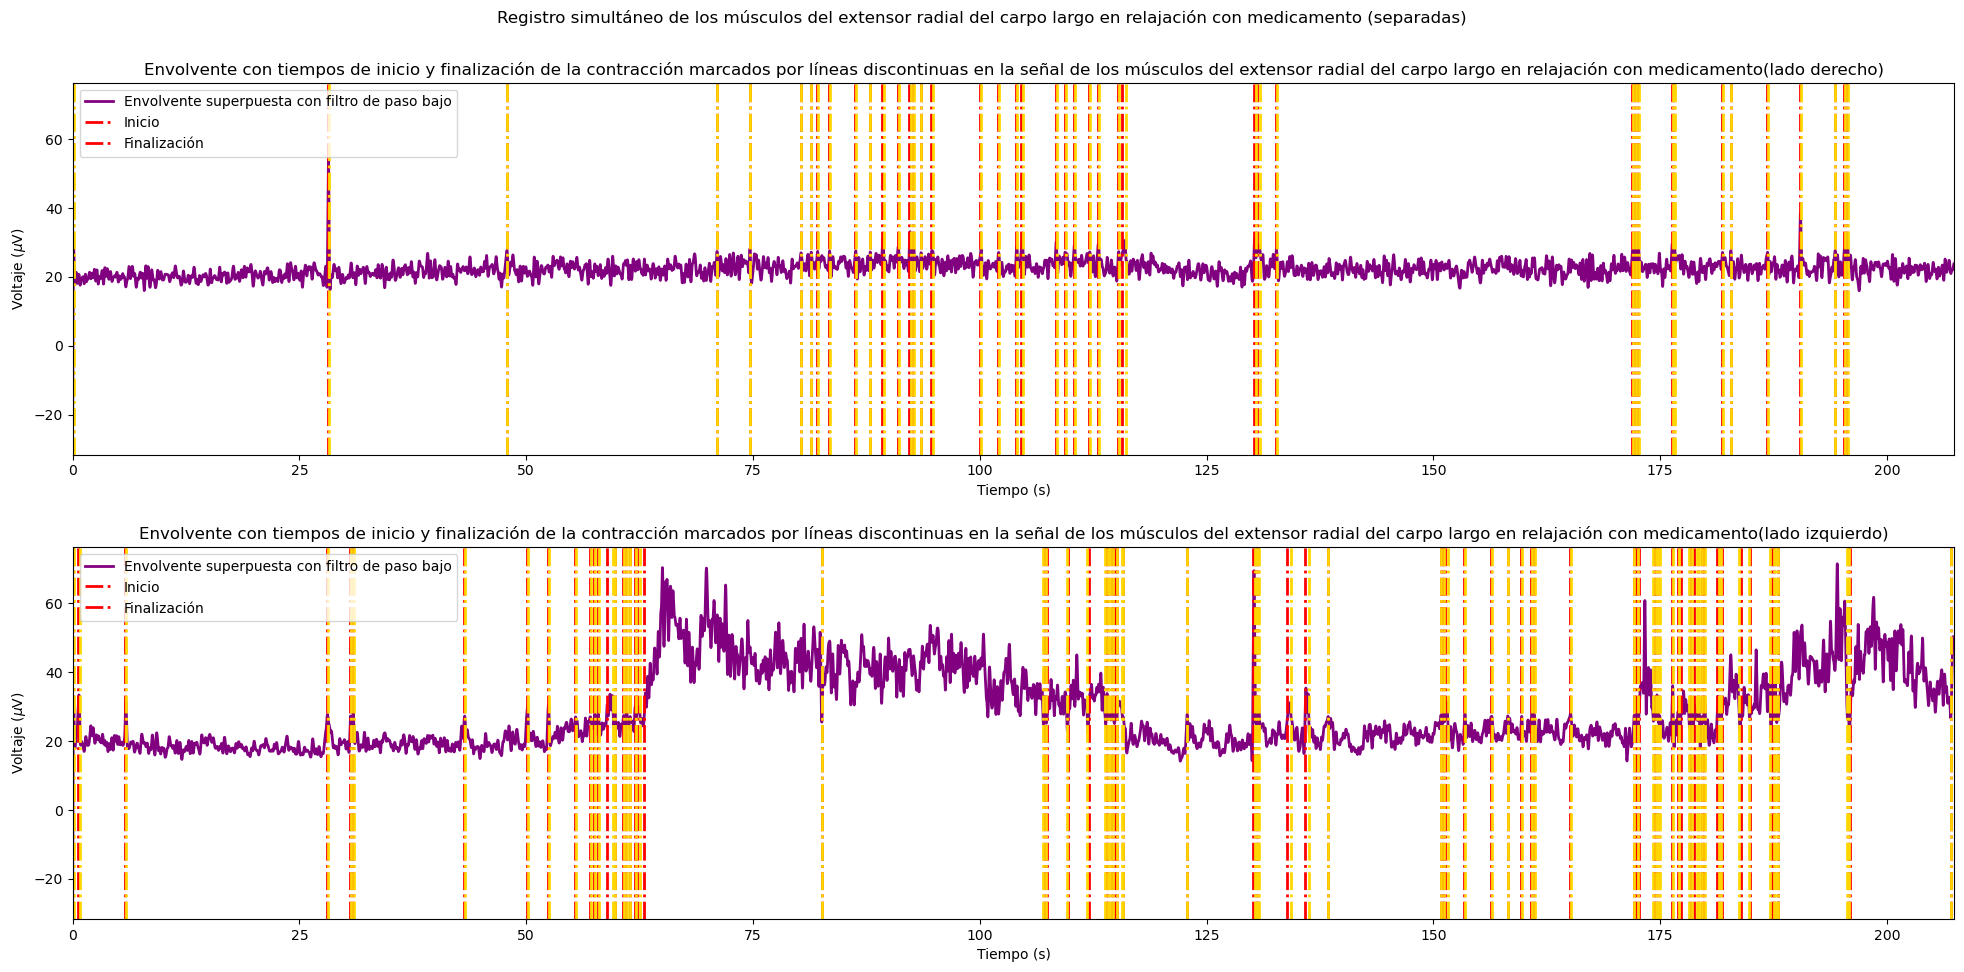

In [26]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# Definir la función para detectar los inicios y finales de la contracción
def detect_contractions(data, threshold):
    starts = []
    stops = []
    for i in range(1, len(data)):
        if data[i-1] < threshold and data[i] >= threshold:
            starts.append(i)
        elif data[i-1] >= threshold and data[i] < threshold:
            stops.append(i)
    return starts, stops

# Filtro Butterworth de paso bajo para detección de envolvente
lowp = 8     
sfrec = 1 / np.mean(np.diff(EMGtiempo))
low_pass = lowp / sfrec
b, a = sc.signal.butter(4, low_pass, btype='lowpass')
datafrle1 = filtfilt(b, a, AbsSeñal1)
datafrle2 = filtfilt(b, a, AbsSeñal2)

# Encontrar umbral automatizado
threshold = np.max(datafrle1) * 0.5

# Detectar inicios y finales de contracciones para cada canal
starts1, stops1 = detect_contractions(datafrle1, threshold)
starts2, stops2 = detect_contractions(datafrle2, threshold)

# Convertir tiempos a segundos
starts1_sec = np.array(starts1) / sfrec
stops1_sec = np.array(stops1) / sfrec
starts2_sec = np.array(starts2) / sfrec
stops2_sec = np.array(stops2) / sfrec

# Trazar envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=True, figsize=(20, 10))
plt.suptitle('Registro simultáneo de los músculos del extensor radial del carpo largo en relajación con medicamento (separadas)')

ax1.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado derecho)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')
ax1.plot(EMGtiempo, datafrle1, 'purple', linewidth=2.0, label="Envolvente superpuesta con filtro de paso bajo")
ax1.set_xlim(0, max(EMGtiempo))
# Para la detección de tiempo de inicio.
for start_sec in starts1_sec:
    ax1.axvline(x=start_sec, color='red', linewidth=2.0, linestyle='-.', label="Inicio")

# Para la detección de tiempo de finalización.
for stop_sec in stops1_sec:
    ax1.axvline(x=stop_sec, color='gold', linewidth=2.0, linestyle='-.', label="Finalización")

ax1.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='best')

ax2.set_title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal de los músculos del extensor radial del carpo largo en relajación con medicamento(lado izquierdo)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')
ax2.plot(EMGtiempo, datafrle2, 'purple', linewidth=2.0, label="Envolvente superpuesta con filtro de paso bajo")
ax2.set_xlim(0, max(EMGtiempo))

# Para la detección de tiempo de inicio.
for start_sec in starts2_sec:
    ax2.axvline(x=start_sec, color='red', linewidth=2.0, linestyle='-.', label="Inicio")

# Para la detección de tiempo de finalización.
for stop_sec in stops2_sec:
    ax2.axvline(x=stop_sec, color='gold', linewidth=2.0, linestyle='-.', label="Finalización")

ax2.legend(['Envolvente superpuesta con filtro de paso bajo', 'Inicio', 'Finalización'], loc='best')

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

# Calcular e imprimir las duraciones de las contracciones en segundos
if len(starts1_sec) > 0 and len(stops1_sec) > 0:
    durs1 = stops1_sec - starts1_sec
    print('Duración de las contracciones en segundos lado derecho:')
    print(durs1)
else:
    print('No se detectaron contracciones en el lado derecho.')

if len(starts2_sec) > 0 and len(stops2_sec) > 0:
    if len(starts2_sec) == len(stops2_sec):
        durs2 = stops2_sec - starts2_sec
        print('Duración de las contracciones en segundos lado izquierdo:')
        print(durs2)
    else:
        print('La detección de inicios y finales de contracciones en el lado izquierdo es inconsistente.')
else:
    print('No se detectaron contracciones en el lado izquierdo.')


print('Duración de las contracciones en segundos lado derecho:')
print(durs1)
print('Duración de las contracciones en segundos lado izquierdo:')
print(durs2)


Algunas señales dan resultados negativos debido a que se desfasa nuestra señal debido al umbral establecido, o en ciertos casos tenemos más valores de detección inicial que valores de detección final. 

Registros y Notebook elaborado por Alejandro Elliot Flores Oliva, licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Autónoma de México (UNAM), correo: elliotflooli@ciencias.unam.mx